# Problem2
## 20M10293 Daisuke Kikuta

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#--------------------#
# function for lasso #
#--------------------#

def soft_thresholding(x, q):
    if   x > q:
        return x - q
    elif x < -q:
        return x + q
    else:
        return 0

def grad(A, w, mu):
    return 2*np.dot((w-mu), A.T)

In [15]:
#------------------------------#
# linear regression with lasso #
#------------------------------#

itr = 300

A   = np.array([[3., 0.5],
                [0.5, 1.]])

mu  = np.array([[1., 2.]])

hp_list = {"lamda=2" : 2, 
           "lamda=4" : 4, 
           "lamda=6" : 6}

L = 4 + 3*np.sqrt(3) # Lipsitz constant

w0_history_tmp = []
w1_history_tmp = []
w0_history = {}
w1_history = {}

for k, hp in hp_list.items():
    w = np.array([[3, -1]])
    for t in range(1, itr):
        w0_history_tmp.append(w[0, 0])
        w1_history_tmp.append(w[0, 1])

        w = w - 1/L*grad(A, w, mu)

        w[0, 0] = soft_thresholding(w[0, 0], hp/L)
        w[0, 1] = soft_thresholding(w[0, 1], hp/L)

    print(k, "optimal weights: ", w)
    w0_history[k]  = w0_history_tmp
    w1_history[k]  = w1_history_tmp
    w0_history_tmp = []
    w1_history_tmp = []

lamda=2 optimal weights:  [[0.81818182 1.09090909]]
lamda=4 optimal weights:  [[0.63636364 0.18181818]]
lamda=6 optimal weights:  [[0.33333333 0.        ]]


Text(0, 0.5, '|| w - w_opt ||')

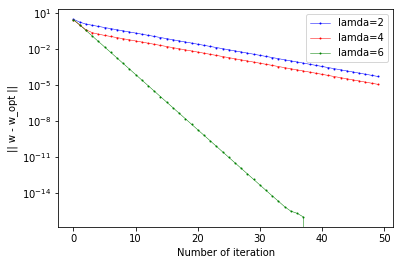

In [16]:
#
#
#

show_itr = 50

color = ["bo-",
         "ro-",
         "go-"]

c = 0
for k, hp in hp_list.items():
    w0_opt = np.abs(w0_history[k][-1])
    w1_opt = np.abs(w1_history[k][-1])

    l2_err = np.sqrt((w0_history[k][:show_itr] - w0_opt)**2 + 
                     (w1_history[k][:show_itr] - w1_opt)**2)

    plt.plot(l2_err[:itr-1], color[c], linewidth=0.5, markersize=1, label=k)
    plt.legend()
    c += 1

plt.yscale("log")
plt.xlabel("Number of iteration")
plt.ylabel("|| w - w_opt ||")

# 2. Regularization path

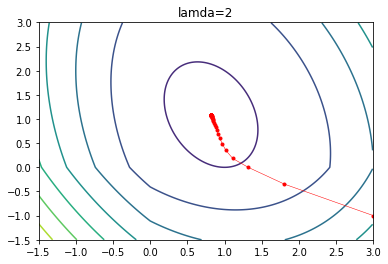

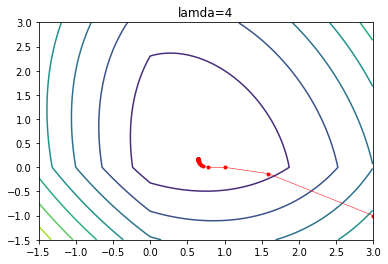

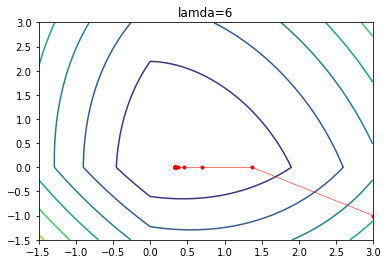

<Figure size 432x288 with 0 Axes>

In [38]:
#-----------------------------#
# drawing regularization path #
#-----------------------------#

for k, hp in hp_list.items():
    w0 = np.arange(-1.5, 3, 0.01)
    w1 = np.arange(-1.5, 3, 0.01)

    X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.01]
    fValue = np.zeros((len(w0), len(w1)))

    for i in range(len(w0)):
        for j in range(len(w1)):
            inr = np.vstack([[w0[i], w1[j]]])
            fValue[i, j] = np.dot(np.dot(inr - mu, A), (inr - mu).T) + hp * (np.abs(w0[i]) + np.abs(w1[j]))

    plt.contour(X1, X2, fValue)

    plt.plot(w0_history[k], w1_history[k], 'ro-', markersize=3, linewidth=0.5)

    plt.xlim(-1.5, 3)
    plt.ylim(-1.5, 3)
    plt.title(k)
    plt.figure()

# 3. Group lasso

In [147]:
#------------#
# dataset VI #
#------------#

d_d6 = 200
n_d6 = 180

# we consider 5 groups where each group has 40 attributes
groupSize = 5
attrSize = 40
g_d6 = np.arange(groupSize*attrSize).reshape(groupSize,-1)

x_d6 = np.random.randn(n_d6, d_d6)
noise_d6 = 0.5

# we consider feature in group 1 and group 2 is activated.
w_d6 = np.vstack([20 * np.random.randn(80, 1),
                 np.zeros((120, 1)),
                 5 * np.random.rand()])
x_d6_tilde = np.hstack([x_d6, np.ones((n_d6, 1))])
y_d6 = np.dot(x_d6_tilde, w_d6) + noise_d6 * np.random.randn(n_d6, 1)

In [148]:
#---------------------------#
# functions for group lasso #
#---------------------------# 

def prox_glasso(mu, q, g):
    sq   = np.dot(mu[g].T, mu[g])
    sqrt = np.float64(np.sqrt(sq))

    if sqrt > 1e-15:
        return max(0., 1 - q/sqrt)*mu[g]
    else:
        return np.zeros(g.shape)

def grad_glasso(X, w, y):
    return np.dot(X.T, np.dot(X, w) - y_d6)

In [149]:
#------------------------------------#
# linear regression with group lasso #
#------------------------------------#

y       = y_d6
x_tilde = x_d6_tilde
w       = w_d6
noise   = noise_d6
n       = n_d6
d       = d_d6
g       = g_d6

# parameters
itr   = 200
hp    = 1.0
la, v = np.linalg.eigh(np.dot(x_tilde.T, x_tilde))
L     = np.max(la) # lipschitz constant

# main loop
for t in range(1, itr):
    w = w - 1/L*grad_glasso(x_tilde, w, y)

    for i in range(0, groupSize):
        w[g[i]] = prox_glasso(w, hp/L, g[i])

# test
x_test = np.random.randn(n, d)
x_test_tilde = np.hstack([x_test, np.ones((n, 1))])
y_test = np.dot(x_test_tilde, w) + noise * np.random.randn(n, 1)
y_pred = np.dot(x_test_tilde, w)
print(np.mean((y_pred - y_test)**2))

0.26738701880637905


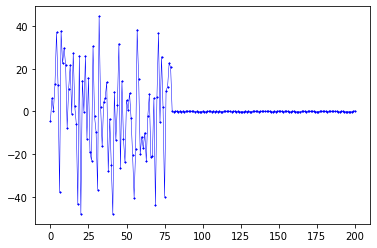

In [150]:
plt.plot(w, 'b-*', markersize=1.5, linewidth=0.5)

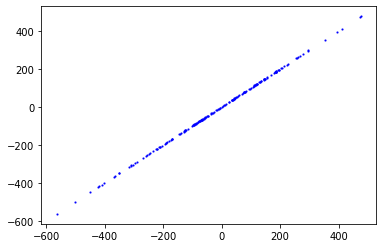

In [151]:
plt.plot(y_test, y_pred, 'bs', markersize=1)

In [152]:
print('carinality of w ground truth: %d'%sum(np.abs(w) < 0.01))

carinality of w ground truth: 20
